In [1]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask
)
from eolearn.ml_tools import TrainTestSplitTask

import os
import dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

data_mask_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task
)

read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    test_count: 1026750
    test_perc: 0.19988525700464715
    train_count: 4109947
    train_perc: 0.8001147429953529
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615')

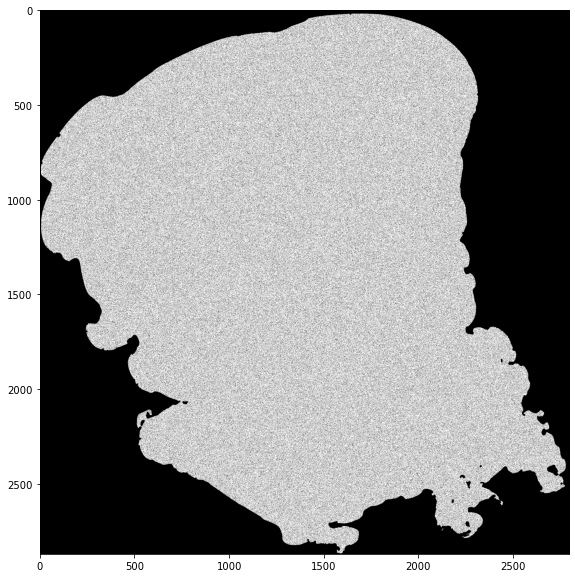

In [3]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False)
plt.show()

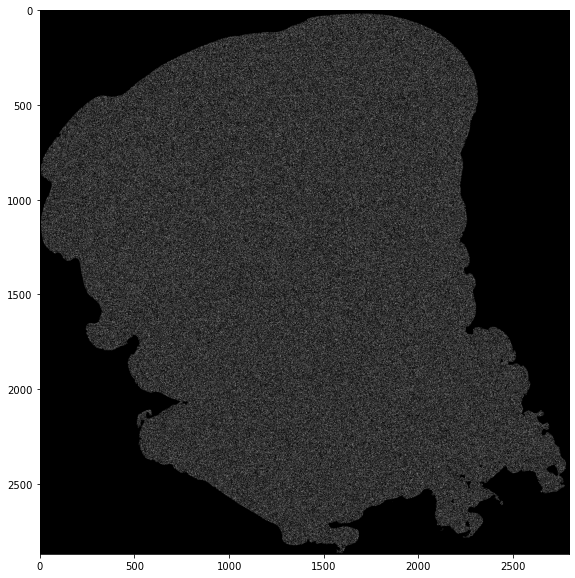

In [4]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False)
plt.show()

### L1C Testing

In [5]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

X_train.shape, y_train.shape

((4109947, 13), (4109947,))

In [6]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-4.5975327833522925, 0.006614261557483508)

In [7]:
model = LGBMRegressor()
model.fit(X_train, y_train)

LGBMRegressor()

In [8]:
X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

X_test.shape, y_test.shape

((1026750, 13), (1026750,))

In [9]:
y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

4.605797245937895

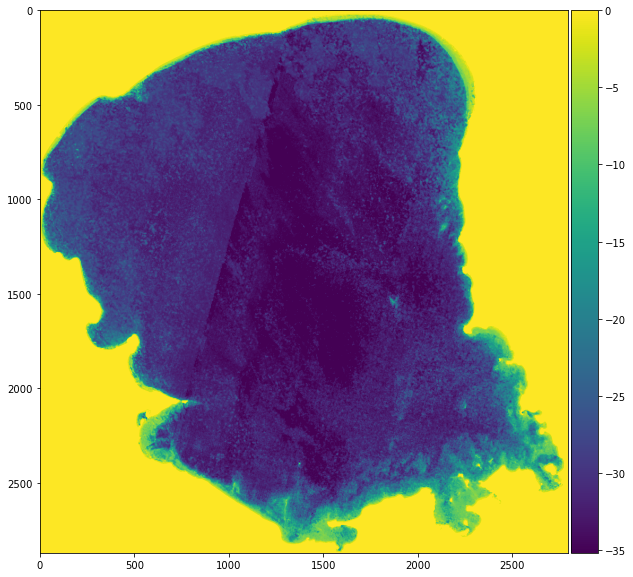

In [10]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature
)

l1c_sdb_estimation_values, l1c_sdb_estimation_map = create_sdb_estimation(
    train_test_eop, model, X_all, mask_feature=data_mask_feature
)
eolx.visualization.plot_ndarray_band(l1c_sdb_estimation_map, cmap='viridis')
plt.show()

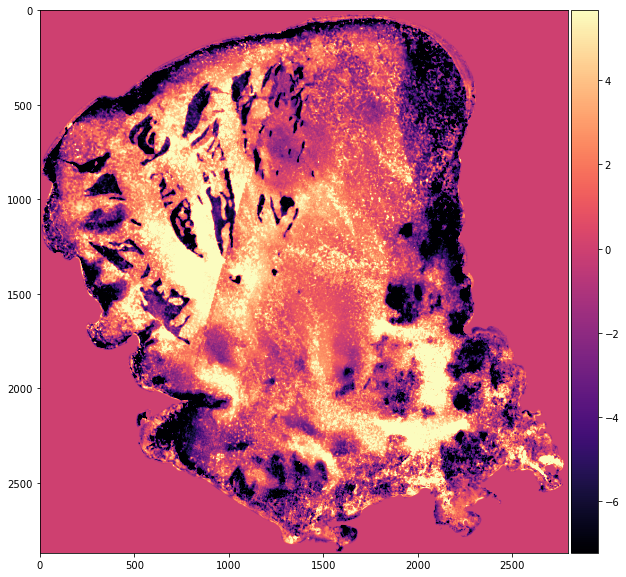

In [11]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l1c_sdb_errors = l1c_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

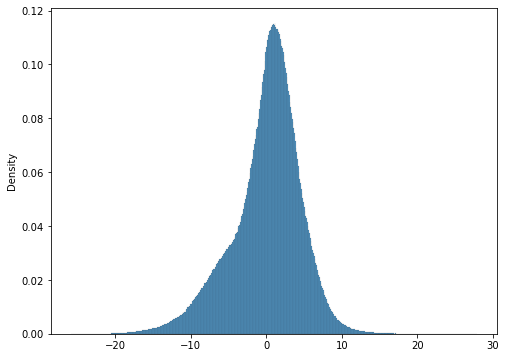

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### L2A Testing

In [13]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-4.5055030527116395, 0.006010769302766944)

In [14]:
model = LGBMRegressor()
model.fit(X_train, y_train)

X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

4.510031648678565

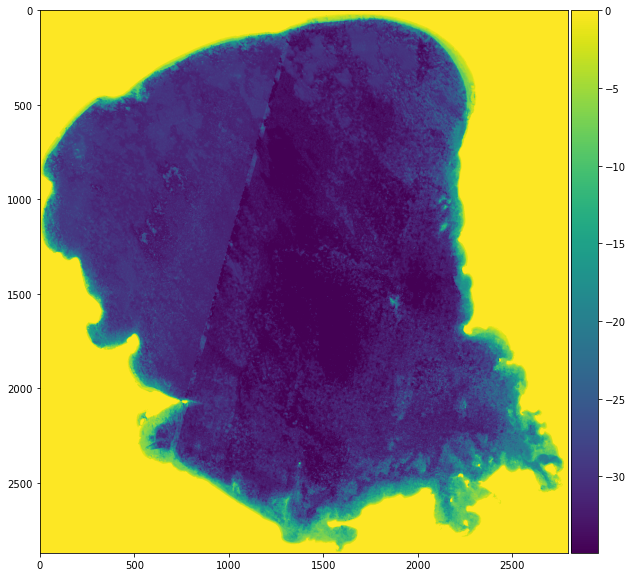

In [16]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(
    train_test_eop, model,
    X_all,
    data_mask_feature
)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

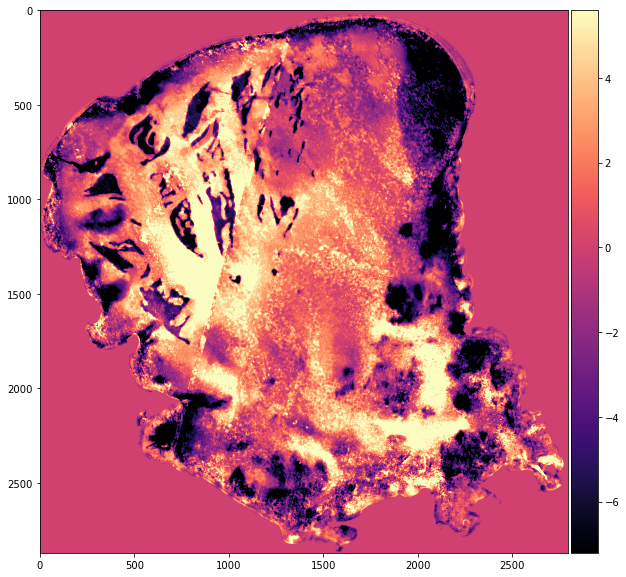

In [17]:
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

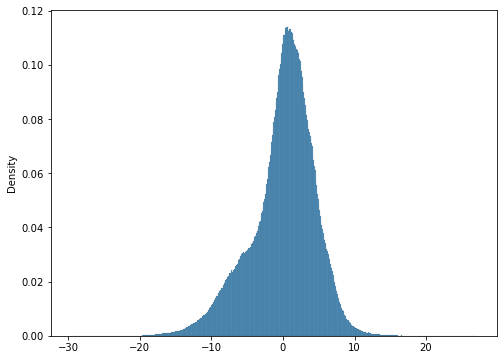

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

### Acolite Testing

In [19]:
acolite_product = 'L2R'
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-5.296411344504727, 0.001571015740481496)

In [20]:
model = LGBMRegressor()
model.fit(X_train, y_train)

X_test, y_test = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Test,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

y_hat_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_hat_test))

5.303912583566788

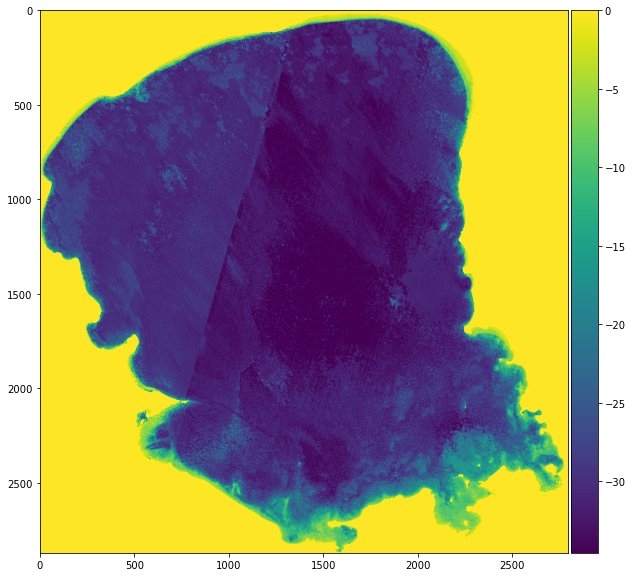

In [21]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=data_mask_feature,
)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(
    train_test_eop, model, X_all, data_mask_feature
)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

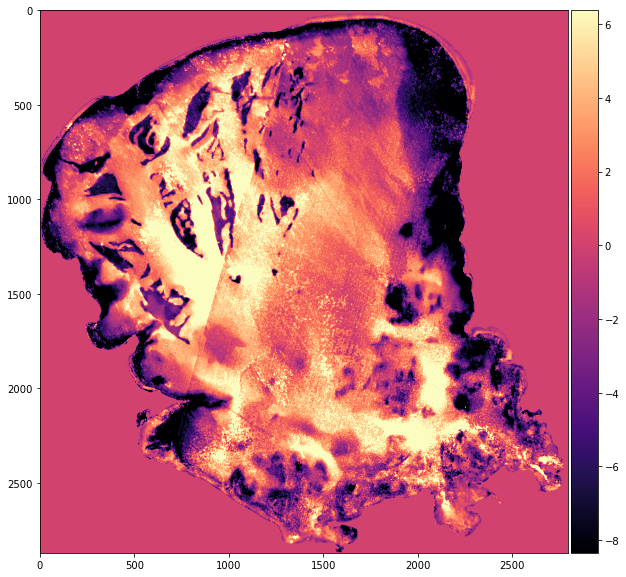

In [22]:
acolite_sdb_errors = acolite_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

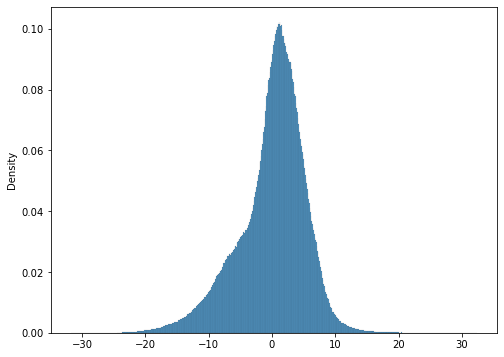

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()